# NIMAの動作確認

## やること

* NIMAを動かす
* instagram_scraperでとってきたラーメン画像100枚でテスト
* やまやの写真でテスト
 - 明度彩度色相を変化させてスコアが変わるか、その変化が主観的な評価と一致するか
 - フレーミングの位置を変えてみてスコアが変わるか、その変化が主観的な評価と一致するか
 
## 注意
汚プログラム

In [2]:
import numpy as np
import argparse
from path import Path
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numba as nb
import time

from keras.models import Model
from keras.layers import Dense, Dropout
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

from utils.score_utils import *

%matplotlib inline

In [3]:
# settings
target_size = (224, 224)
evaluate_dir = './images/'
print("Loading images from directory : ",evaluate_dir)
imgs = Path(evaluate_dir).files('*.png')
imgs += Path(evaluate_dir).files('*.jpg')
imgs += Path(evaluate_dir).files('*.jpeg')

Loading images from directory :  ./images/


In [5]:
def get_image_array(path):
    im = Image.open(path)
    im_array = np.asarray(im)
    return im_array

In [6]:
def display_images(images, score_list=None, func=None):
    fig = plt.figure(figsize=(16, 10))
    
    for i in range(len(images)):
        ax = fig.add_subplot(2, 3, i+1)
        ax.tick_params(labelbottom="off", bottom="off", labelleft="off", left="off")
        if func is not None:
            image = func(images[i])
            ax.imshow(image)
        else:
            ax.imshow(images[i])
        if score_list is not None:
            ax.set_title("{:5f}".format(score_list[i]))
        
    plt.show()

In [7]:
def display_images_from_path(path_list, score_list, std_list):
    fig = plt.figure(figsize=(16, 12))
    
    for i, (path, score, std) in enumerate(zip(path_list, score_list, std_list)):
        image = get_image_array(path)
        ax = fig.add_subplot(4, 3, i+1)
        ax.tick_params(labelbottom="off", bottom="off", labelleft="off", left="off") 
        ax.imshow(image)
        ax.set_title("{} : {:5f}(+-{:3f})".format(path.rsplit("/")[-1], score, std))
        
    plt.show()

## インスタの写真でチェック
「ラーメン」でとってきた100枚を使う。
なお、ラーメン以外の写真はめんどくさいので手で除外した。
分類器を作る必要があるなぁ。

#### TIPS
* kerasの構築済みのMobileNetはImageNetを学習した重みを持っているらしい。(このプログラムでは関係ないけど)
* weightsは実装済みページにリンクがあるのでそこからダウンロード

In [4]:
with tf.device('/CPU:0'):
    base_model = MobileNet((None, None, 3), alpha=1, include_top=False, pooling='avg', weights=None)
    x = Dropout(0.75)(base_model.output)
    x = Dense(10, activation='softmax')(x)

    model = Model(base_model.input, x)
    model.load_weights('weights/mobilenet_weights.h5')

    score_list = []
    predict_time = []
    process_time = []

    for img_path in imgs:
        process_start = time.time()
        
        img = load_img(img_path, target_size=target_size)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    
        predict_start = time.time()
        scores = model.predict(x, batch_size=1, verbose=0)[0]
        predict_time.append(time.time() - predict_start)
        process_time.append(time.time() - process_start)

        mean = mean_score(scores)
        std = std_score(scores)

        file_name = Path(img_path).name.lower()
        score_list.append((file_name, mean, std))

In [6]:
np.array(predict_time).mean(), np.array(process_time).mean(), 

(0.1201624870300293, 0.16142742200331253)

### BEST10とWORST10を表示
主観的な評価と一致するかな？(汚いコードが出てきます、ごめんなさい)

top 10


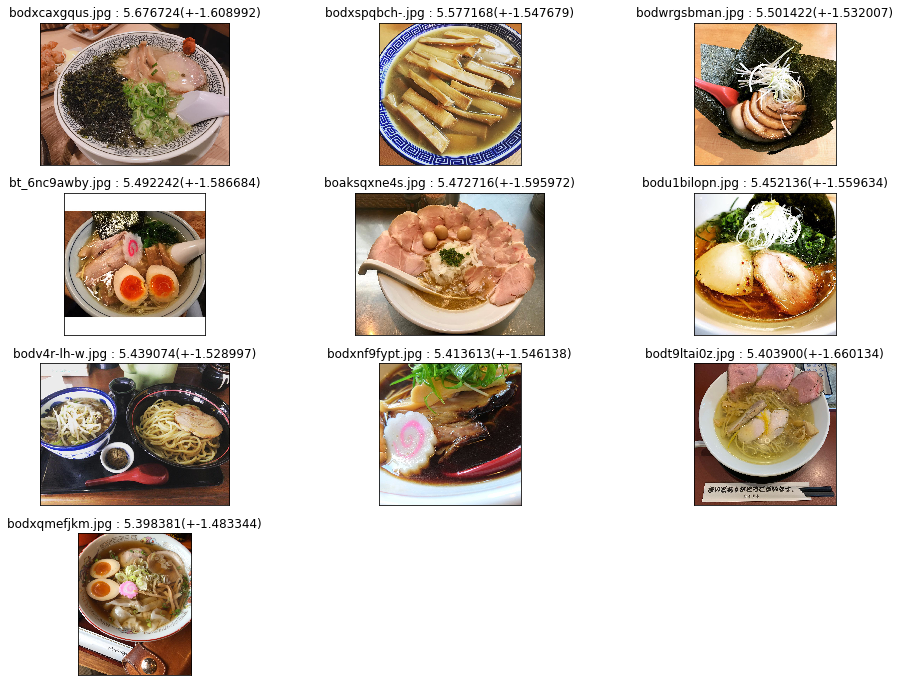

bottom 10


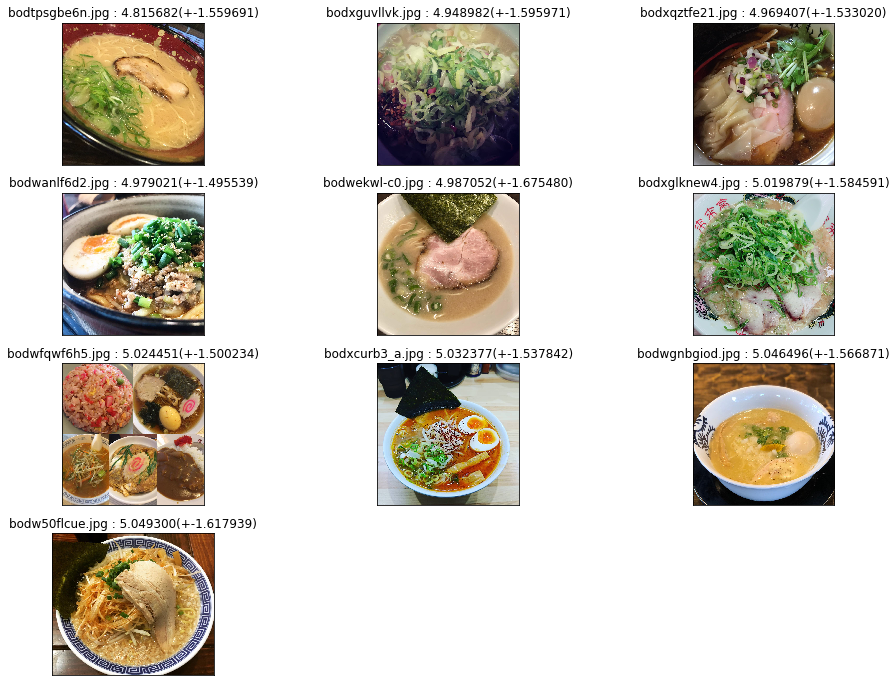

In [10]:
# display top 10 
ranked_paths, ranked_scores, ranked_stds = [], [], []
[(ranked_paths.append(evaluate_dir+li[0]), ranked_scores.append(li[1]), ranked_stds.append(li[2])) \
    for li in sorted(score_list, key=lambda x: x[1], reverse=True)]
print("top 10")
display_images_from_path(ranked_paths[:10], ranked_scores[:10], ranked_stds[:10])

# display bottom 10
print("bottom 10")
display_images_from_path(ranked_paths[::-1][:10], ranked_scores[::-1][:10], ranked_stds[::-1][:10])

### 所感

完全に主観的な意見になってしまうけど、どっこいどっこいでは？笑

いかんせん画像の感じが似通っているのでパッと比べるのは難しい感じ

### やまやの画像をいじる

やまやの画像のHSVを変調してみたり、フレーミングを変えてみてどうなるかテスト

In [11]:
# 変換行列を作る
# numbaに合わせてちょっと冗長になってる
@nb.jit('f8[:, :, :, :](f8[:, :, :], UniTuple(f8[:], 2), UniTuple(f8[:], 2), UniTuple(f8[:], 2), f8, f8, f8)')
def create_transformation_matrix(image_array, h_range=(0.85, 1.15), s_range=(0.75, 1.25), v_range=(0.75, 1.25), h_num=5, s_num=5, v_num=5):
    matrix = np.ones((h_num*s_num*v_num, image_array.shape[0], image_array.shape[1], image_array.shape[2]))
    h_list = list(np.linspace(h_range[0], h_range[1], h_num))
    s_list = list(np.linspace(s_range[0], s_range[1], s_num))
    v_list = list(np.linspace(v_range[0], v_range[1], v_num))
    
    index = 0
    for h in h_list:
        for s in s_list:
            for v in v_list:
                matrix[index] = matrix[index] * np.array([h, s, v])
                index = index + 1
                
    return matrix

In [12]:
def convert_hsv2rgb(hsv_image):
    rgb_image = cv2.cvtColor(hsv_image.astype(np.float32), cv2.COLOR_HSV2RGB).astype(np.uint8)
    return rgb_image

### 適当に変換してスコアを見る
HSVを適当なレンジでそれぞれいじってみる。それぞれ5種類用意してみたので、125パターンある。

original


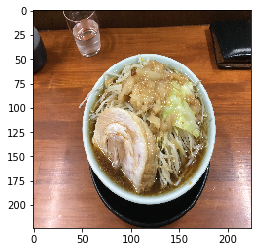

transformed


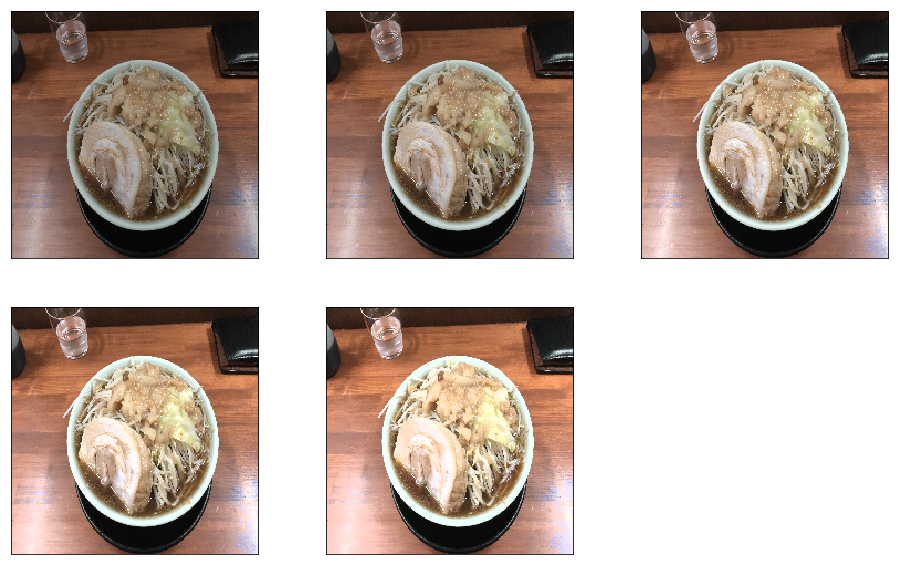

In [13]:
# transformation
image = load_img('./images/test/yamaya.JPG', target_size=target_size)
print("original")
plt.imshow(image)
plt.show()
im_arr = img_to_array(image)
im_arr = cv2.cvtColor(im_arr, cv2.COLOR_RGB2HSV)

change_matrix = create_transformation_matrix(im_arr)
images = change_matrix * im_arr
images[np.where(images>255)] = 255
images[np.where(images<0)] = 0

# check
print("transformed")
display_images(images[:5], func=convert_hsv2rgb)

score
min : 5.484218638041057
max : 5.559990975190885


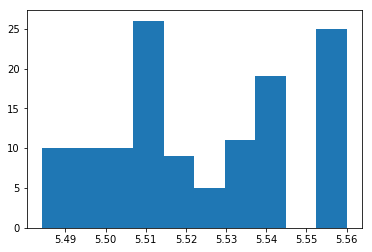

In [14]:
# check_score
x = preprocess_input(images.copy())

scores = model.predict(x, batch_size=1, verbose=0)
mean_array = mean_score_batch(scores)

print("score")
print("min : {}".format(mean_array.min()))
print("max : {}".format(mean_array.max()))
plt.hist(mean_array)
plt.show()

インスタの画像と同じようにスコアリングに主観的な違いがあるか見てみる

top 5


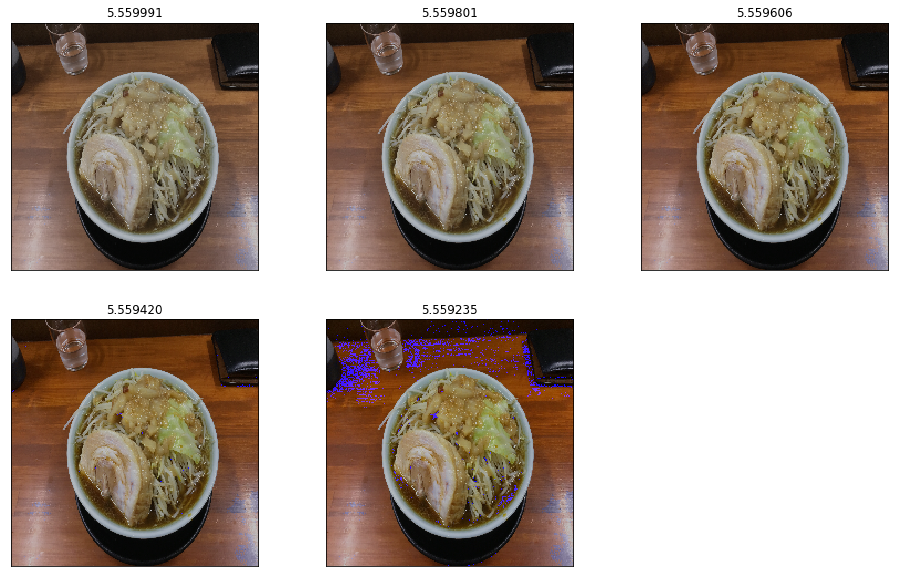

bottom 5


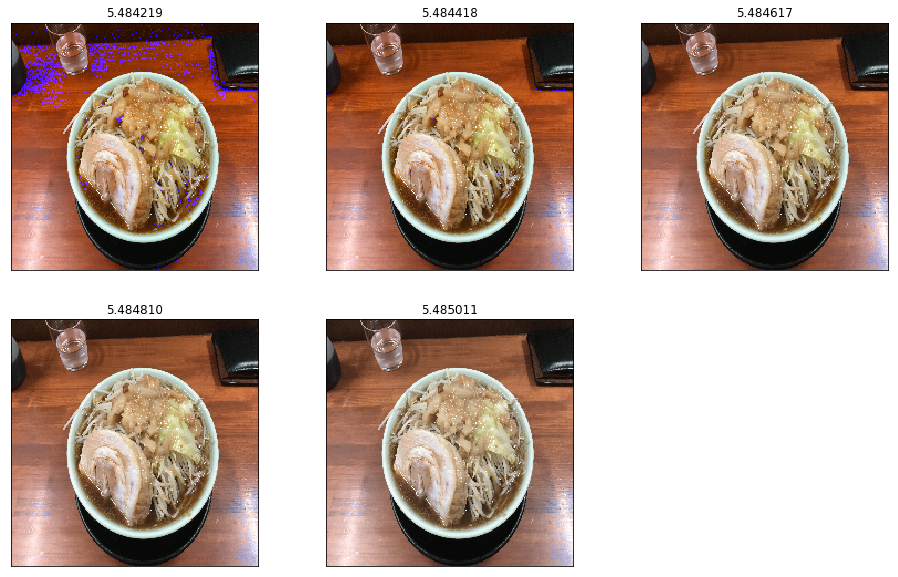

In [15]:
# display top 5 and bottom 5
top_index = np.argsort(-mean_array)[:5]
bottom_index = np.argsort(mean_array)[:5]

print("top 5")
display_images(images[top_index], score_list=mean_array[top_index], func=convert_hsv2rgb)
print("bottom 5")
display_images(images[bottom_index], score_list=mean_array[bottom_index], func=convert_hsv2rgb)

下の画像が良いと言う人もいそう！笑

一つ言えるのはHSVの変化によってスコアは大きく上下しなさそうだ、と言うこと。

### トリミングの仕方で変わるかどうか選手権

画像の切り出す位置を適当に変えてみてどうなるか検証してみる。

In [16]:
def convert_npuint8(image):
    return image.astype(np.uint8)

def trim_image(image, x_range, y_range):
    return image[x_range[0]:x_range[1], y_range[0]:y_range[1], :]

In [17]:
# trimming and scoring
big_image = load_img('./images/test/yamaya.JPG', target_size=(324, 324))
big_im_array = img_to_array(big_image)

trim_scores = []

for y_add in range(0, 101, 10):
    for x_add in range(0, 101, 10):
        x_range = (0+x_add, 224+x_add)
        y_range = (0+y_add, 224+y_add)
        x = np.expand_dims(trim_image(big_im_array, x_range, y_range), axis=0)
        x = preprocess_input(x.copy())
        
        scores = model.predict(x, batch_size=1, verbose=0)[0]
        mean = mean_score(scores)
        std = std_score(scores)
        
        trim_scores.append((x_range[0], y_range[0], mean, std))

top5


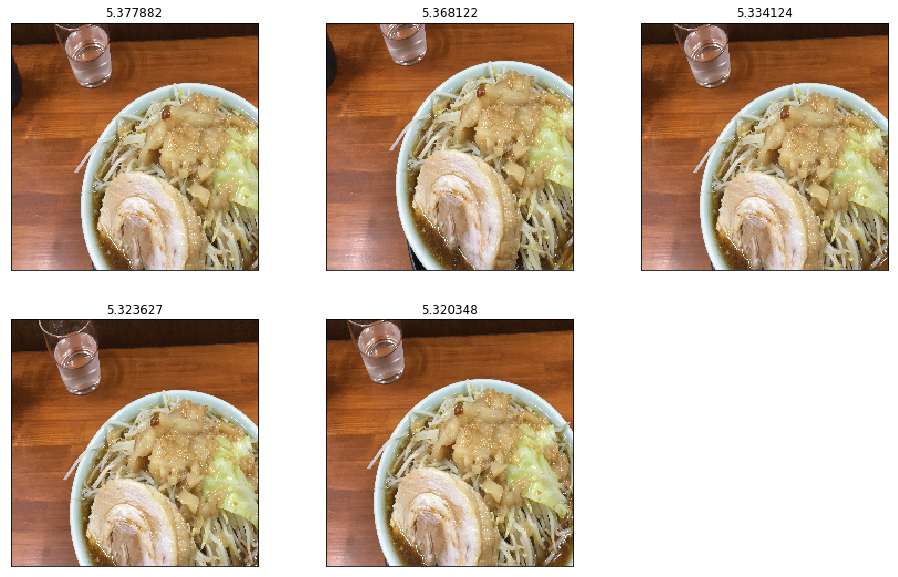

bottom5


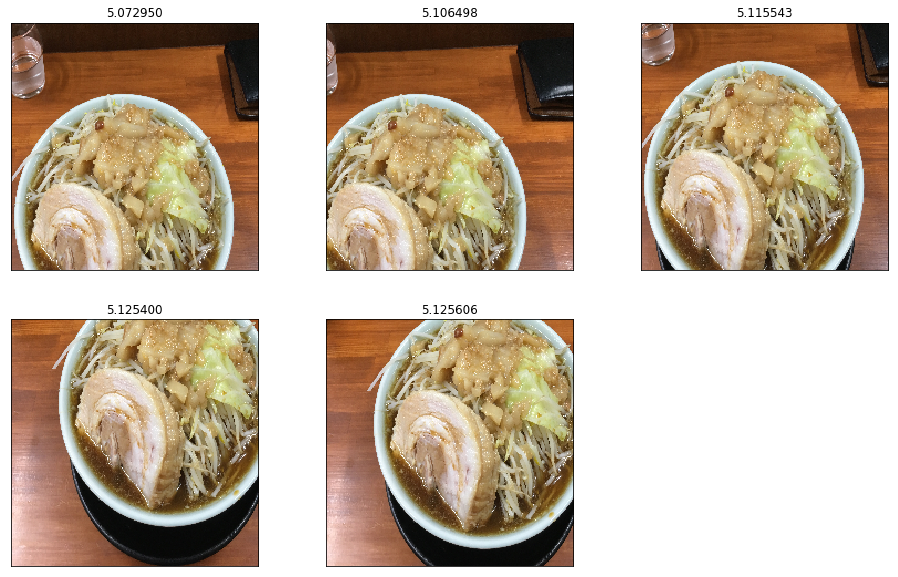

In [18]:
trim_points, trim_means, trim_stds = [], [], []
[(trim_points.append((li[0], li[1])), trim_means.append(li[2]), trim_stds.append(li[3])) \
    for li in sorted(trim_scores, key=lambda x: x[2], reverse=True)]

# top 5
print("top5")
trim_top5_images = [trim_image(big_im_array, (0+xs, 224+xs), (0+ys, 224+ys)) for xs, ys in trim_points[:5]]
display_images(trim_top5_images, score_list=trim_means[:5], func=convert_npuint8)

# bottom 5
print("bottom5")
trim_bottom5_images =  [trim_image(big_im_array, (0+xs, 224+xs), (0+ys, 224+ys)) for xs, ys in trim_points[::-1][:5]]
display_images(trim_bottom5_images, score_list=trim_means[::-1][:5], func=convert_npuint8)

### トリミングによるスコアの変化

HSVをいじった場合とではスコアの振れ幅に大きな差が出る。
中央に被写体があれば良いと言うわけでもなく、右下にあるのが最も審美的らしい。

この辺は個人的には自分のセンスと一致する…が、お店側としては当然全体の写真をとってもらう方が嬉しそう？
一方で実際斜めから写した食べ物の写真なんかは美味しそうかつオシャレに見えたりする。難しいところ。

## まとめ

NIMAのスコアを信用できるかどうか、もう少しいろんなパターンでの検証が必要かもしれない。

次の作業について話しましょう〜